In [ ]:
######################################### NOTES ###############################################
# * Cross Validation
#   * Data is split into k folds and then is used to train a model k times 
#   * On each iteration, k-1 of those folds are used for training and the remaining fold 
#     is the test set. The cross validation is run until each fold has been used as the test
#     set.
#   * The cross validation score is the average score of each of the model results (r2/explained
#     variance for regression, accuracy for classification)
#   * Best practice is to use 5 or 10 folds for optimal score
#   * However, if the learning curve is steep for the training size in question, then 5- or 
#     10- fold cross validation can overestimate the generalization error.
# * Boostrap Statistics
#   * To get a bootstrap statistic, a data set is resampled k times where k
#     is the number of data points (len(x)). Then you take the statistic of that resampled
#     data.
#   * Running the bootstrap a large number of times is better as it will more closely reflect
#     the test statistic. If you plot the list of resulting statistics from those boostraps, 
#     it will be in the shape of a Gaussian distibution
#
################################################################################################

In [1]:
# Import packages

import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)

In [3]:
# Configure SQL

def execute_statement(sql: str):
    with psycopg2.connect(host="localhost", database="thefantasybot", user="tbakely") as conn:
         df = pd.read_sql(sql, conn)
         return df

weekly_sql = """
select
	wd.player_id,
	wd.player_name,
	position,
	recent_team,
	wd.season,
	wd.week,
	carries,
	rushing_yards,
	rushing_tds,
	rushing_fumbles,
	rushing_fumbles_lost,
	rushing_first_downs,
	rushing_epa,
	--efficiency,
	--percent_attempts_gte_eight_defenders,
	--avg_time_to_los,
	--rush_yards_over_expected,
	--avg_rush_yards,
	--rush_yards_over_expected_per_att,
	--rush_pct_over_expected,
	wd.receptions,
	wd.targets,
	receiving_yards,
	receiving_tds,
	receiving_fumbles,
	receiving_fumbles_lost,
	receiving_air_yards,
	receiving_yards_after_catch,
	receiving_first_downs,
	receiving_epa,
	racr,
	target_share,
	air_yards_share,
	wopr,
	offense_snaps,
	offense_pct,
    redzone.redzone,
	(carries + wd.targets) as total_usage,
    wd.fantasy_points,
    wd.fantasy_points_ppr,
	roof,
	surface,
	weather_hazards,
	temp,
	humidity,
	wind_speed
from archive_data.weekly_data wd
left join archive_data.offense_snap_counts os
on wd.player_id = os.id
and wd.season = os.season
and wd.week = os.week
left join archive_data.ngs_rushing_data ngsr
on wd.player_id = ngsr.player_gsis_id
and wd.season = ngsr.season
and wd.week = ngsr.week
left join archive_data.ngs_receiving_data ngsrr
on wd.player_id = ngsrr.player_gsis_id
and wd.season = ngsrr.season
and wd.week = ngsrr.week
left join (select distinct rusher_player_id, game_id, season, week from archive_data.full_pbp) game_id
on wd.player_id = game_id.rusher_player_id
and wd.season = game_id.season
and wd.week = game_id.week
left join archive_data.game_data
on game_data.game_id = game_id.game_id
left join archive_data.redzone_snaps redzone
on wd.player_id = redzone.player_id
and wd.season = redzone.season
and wd.week = redzone.week
where position in ('WR', 'RB', 'TE')
and wd.season between 2016 and 2022;
"""

# Load weekly data from 2016-2022; Modify above query as needed
weekly = execute_statement(weekly_sql)

# Dealing with null values
weekly1 = weekly.copy()
weekly1.dropna(subset=["player_name"], inplace=True)
weekly1.dropna(subset=["offense_snaps"], inplace=True)

fill_na_cols = [
    "rushing_epa",
    "receiving_epa",
    "racr",
    "target_share",
    "air_yards_share",
    "wopr",
    "redzone",
]

weather_cols = [
    "roof",
    "surface",
    "weather_hazards",
    "temp",
    "humidity",
    "wind_speed",
]

for col in fill_na_cols:
    weekly1[col] = weekly[col].fillna(0)

weekly1 = weekly1[[col for col in weekly1.columns if col not in weather_cols]]
weekly1["week"] = weekly1["week"].astype(str)
weekly1["season"] = weekly1["season"].astype(str)

In [4]:
weekly1["scored"] = np.where((weekly1["receiving_tds"] > 0) | (weekly1["rushing_tds"] > 0), 1, 0)
weekly1["multi_score"] = np.where(weekly1["receiving_tds"] + weekly1["rushing_tds"] > 1, 1, 0)
weekly1["total_yards"] = weekly1["rushing_yards"] + weekly1["receiving_yards"]
weekly1["total_epa"] = weekly1["rushing_epa"] + weekly1["receiving_epa"]
weekly1["total_first_downs"] = weekly1["rushing_first_downs"] + weekly1["receiving_first_downs"]


try_columns = ["total_epa", "total_first_downs", "target_share", "redzone", "offense_pct", "total_usage"]


model_data = weekly1[try_columns]
model_data.head()

,total_epa,total_first_downs,target_share,redzone,offense_pct,total_usage
14,-0.258469,0.0,0.111111,0.0,0.66,4
15,0.662646,2.0,0.200000,3.0,0.53,5
16,-0.809390,2.0,0.166667,1.0,0.35,5
17,-0.385813,2.0,0.206897,0.0,0.47,6
18,1.970081,3.0,0.227273,3.0,0.51,10


In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

model = LinearDiscriminantAnalysis()

y = weekly1[["scored"]].values
X = model_data.values
folds = 10

cross_val_array = cross_val_score(model, X, y, cv=folds)
avg_score = np.mean(cross_val_array)
print(f"Array:\n{cross_val_array}\nAvg Score:\n{avg_score}")

Array:
[0.8255814  0.82848837 0.82390953 0.84006462 0.85266559 0.84458805
 0.83489499 0.82778675 0.84749596 0.8361874 ]
Avg Score:
0.8361662659202764


In [36]:
# Use the following link for predefined scoring methods to pass into the scoring argument in cross_validate
# https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules

from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, make_scorer

# cross_validation = cross_val_score(model, X, y, cv=folds, scoring=make_scorer(accuracy_score))
cross_validation = cross_val_score(model, X, y, cv=folds, scoring="accuracy")
avg_score = np.mean(cross_validation)

# Can use cross_validate to pass in multiple scoring methods when 
# cross_validation = cross_validate(model, X, y, cv=folds, scoring=["accuracy", "recall"])
# cross_val_array = cross_validation["test_score"]
# avg_score = np.mean(cross_val_array)

print(f"Array:\n{cross_validation}\nAvg Score:\n{avg_score}")

Array:
[0.8255814  0.82848837 0.82390953 0.84006462 0.85266559 0.84458805
 0.83489499 0.82778675 0.84749596 0.8361874 ]
Avg Score:
0.8361662659202764


array([0.8255814 , 0.82848837, 0.82390953, 0.84006462, 0.85266559,
       0.84458805, 0.83489499, 0.82778675, 0.84749596, 0.8361874 ])

In [41]:
# Cross validation iterator
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(model, X, y, cv=cv, scoring="accuracy")

array([0.83448202, 0.83814344, 0.83706655, 0.83189748, 0.83868189])

In [83]:
# Bootstrap methods
from sklearn.utils import resample

# Target share array from model data
target_share = X[:, 2]

# Resampling the target share
def bootstrap_stat(array: np.array, n_bootstraps: int, statfunc, **kwargs):
    results = []
    for k in range(n_bootstraps):
        results.append(statfunc(resample(array, **kwargs)))
    return results

Result: 0.119805429363125
Real Result: 0.11772378934459808
Std Dev: 0.015702936037121504


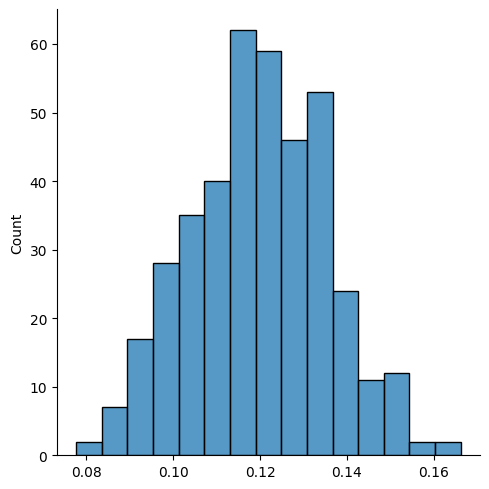

In [96]:
bootstrap_results = bootstrap_stat(array=target_share, n_bootstraps=400, statfunc=np.mean, n_samples=40, replace=True)
print(f"Result: {np.mean(bootstrap_results)}\nReal Result: {np.mean(target_share)}\nStd Dev: {np.std(bootstrap_results)}")
sns.displot(bootstrap_results)
plt.show()